In [8]:
# 房价预测abs
import tensorflow as tf
import ssl
import numpy as np
import matplotlib.pyplot as plt

ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
(train_data, train_targets), (test_data, test_targets) = tf.keras.datasets.boston_housing.load_data()

In [57]:
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
len(train_data)
# 数据量很少

(404, 13)
(102, 13)
(404,)


404

In [14]:
print(train_data[0])
# 房价中位数
train_targets.shape

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


(404,)

In [32]:
# 数据标准化
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [55]:
# 数据量小，不能构造过多的网络层
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


In [56]:
# k-fold处理法，交叉, 数据量小的时候
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_socres = []

for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        (train_data[: i * num_val_samples],train_data[(i+1) * num_val_samples:]),
        axis=0)
    partial_train_targets = np.concatenate(
        (train_targets[: i * num_val_samples], train_targets[(i+1) * num_val_samples:]),
        axis=0) 
    
    print("build_model")
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, 
             batch_size=1, verbose=0)
    print("evaluate..")
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_socres.append(val_mae)
    
print(all_socres)
                               

processing fold # 0
build_model
evaluate..
processing fold # 1
build_model
evaluate..
processing fold # 2
build_model
evaluate..
processing fold # 3
build_model
evaluate..
[2.6731355, 2.8332748, 2.3887591, 2.522097]


In [61]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k #整数除法
num_epochs = 200
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    #依次把k分数据中的每一份作为校验数据集
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i* num_val_samples : (i+1) * num_val_samples]
    
    #把剩下的k-1分数据作为训练数据,如果第i分数据作为校验数据，那么把前i-1份和第i份之后的数据连起来
    partial_train_data = np.concatenate([train_data[: i * num_val_samples], 
                                         train_data[(i+1) * num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], 
                                            train_targets[(i+1) * num_val_samples: ]],
                                          axis = 0)
    print("build model")
    model = build_model()
    #把分割好的训练数据和校验数据输入网络
    history = model.fit(partial_train_data, partial_train_targets, 
              validation_data=(val_data, val_targets),
              epochs = num_epochs, 
              batch_size = 16, verbose = 0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history) 

processing fold # 0
build model
processing fold # 1
build model
processing fold # 2
build model
processing fold # 3
build model


In [70]:
print(len(all_mae_histories))
print(len(all_mae_histories[0]))
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
print(len(average_mae_history))


4
200
200


In [75]:
print(average_mae_history[0])
len(average_mae_history)

19.179571


200

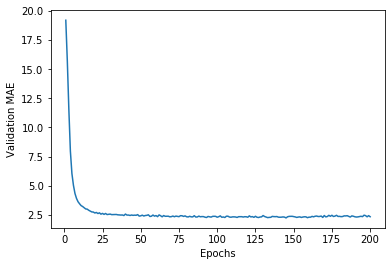

In [76]:
from matplotlib import pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

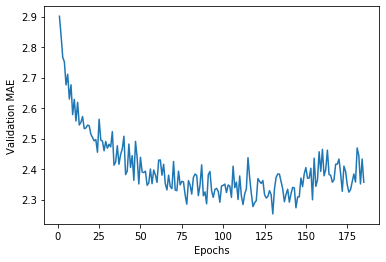

In [95]:
def smooth_curve(points, factor=0.9):
    """指数滑动平均"""
    smooth_points = []
    for t in range(len(points)):
        if t == 0:
            smooth_points.append(points[t])
        else:
            new_point_t = factor * points[t] + (1 - factor) * smooth_points[t-1]
            smooth_points.append(new_point_t)
    return smooth_points

smooth_history = smooth_curve(average_mae_history[15:], 0.9)
plt.plot(range(1, len(smooth_history) + 1), smooth_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()